# Plotting On-Site Releases from the TRI Report

For this notebook, I'm keeping the date range small and only looking at the 2013-2015 reports while I get some of my methods working the way I want them too.

Right now I am plotting the reported On-Site Releases from the TRI Report in the state of NC (though this can fairly easily be re-focused on any state or city or lat/lon region). The size of the point on the map is proportional to the volume of chemical reported released at that facility.  
I'm only considering the On-Site Releases right now since we know exactly where those releases are occuring. Off-Site Releases, though still significant, are not linked directly to a lat/lon for where they are happening, unless I'm completely mis-reading the dataset.

A few problems that I know I currently have with this are  
1 - Showing the accumulation of releases over time. I'm currently leaning towards showing each year as its own data set, marked by a different color, though I am extremely open to any other suggestions  
2 - The scale to use on the map. Some facilities report releses measured in tens of thousands of pounds, some reports are for just a few grams. I am currently using a logarthmic scale to try and account for that, but the small releases are still getting lost on the map.

### Imports

Nothing crazy here. Basemap, numpy, pandas. The matplotlib.cm import is for colormaps which are used in the scatter plot

In [1]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy, pandas

### Importing Data

There is a lot of information in the TRI reports, so to speed up parsing the files I am only using a small subset of this data. Specifcally:

    YEAR
    TRI_FACILITY_ID
    FACILITY_NAME
    STREET_ADDRESS
    CITY
    ST
    ZIP
    LATITUDE
    LONGITUDE
    CHEMICAL
    UNIT_OF_MEASURE
    ON-SITE_RELEASE_TOTAL
    
This is the positional data, the type of chemical released, and the total amount that is released on-site. I'm ignoring off-site releases because as far as I can tell there is no real way to determine where those releases are actually occuring relative to the reporting facility.

In [2]:
theseCols = ['YEAR', 'TRI_FACILITY_ID', 'FACILITY_NAME', 'STREET_ADDRESS', 'CITY', 'ST', 'ZIP', 'LATITUDE', 'LONGITUDE', 'CHEMICAL', 'UNIT_OF_MEASURE', 'ON-SITE_RELEASE_TOTAL']

Reading in the data sets using specified columns

In [3]:
tri2013 = pandas.read_csv("DATA/TRI_DATA/TRI_2013_US.csv", usecols=theseCols)
tri2014 = pandas.read_csv("DATA/TRI_DATA/TRI_2014_US.csv", usecols=theseCols)
tri2015 = pandas.read_csv("DATA/TRI_DATA/TRI_2015_US.csv", usecols=theseCols)

Pulling out the NC data

In [4]:
#Pull out North Carolina data
tri2013NC = tri2013[(tri2013['ST'] == 'NC')].copy()
tri2014NC = tri2014[(tri2014['ST'] == 'NC')].copy()
tri2015NC = tri2015[(tri2015['ST'] == 'NC')].copy()

The index numbers are all over the place when pulling out the specific state data, so I re-index them sequentially just to make it a little easier to deal with them later on.

In [5]:
#Reindex the data so it is sequentially id'd

tri2013NC.index = range(len(tri2013NC.index))
tri2014NC.index = range(len(tri2014NC.index))
tri2015NC.index = range(len(tri2015NC.index))

#### dropAndConvert

I am only looking at reports that have values for On-Site Releases. Not every report filed covers On-Site Releases, so we need to go through the frame and drop any row that has a 0 for on site releases.

Also, so reports measure their releases in pounds, and some in grams. So while we are iterating through the dataframe looking for on-site releases of 0, we go ahead and convert any gram measurements to pounds.

In [6]:
def dropAndConvert(frame):
    #Initialize a list to track the indexes of 0 on-site release reports
    noOnSite = []
    
    #Iterate through the rows in the frame and find the rows with a 0 in the On-Site Release field
    for i in frame.index:
        if frame.iloc[i]['ON-SITE_RELEASE_TOTAL']  == 0:
            noOnSite.append(frame.iloc[i].name)
        if frame.loc[i, ('UNIT_OF_MEASURE')] == 'Grams':
            frame.loc[i, ('ON-SITE_RELEASE_TOTAL')] *= 0.00220462
            frame.loc[i, ('UNIT_OF_MEASURE')] = 'Pounds'
            
    #Return a new dataframe with those entries dropped from the original frame
    return frame.drop(noOnSite)

In [7]:
tri2013NC = dropAndConvert(tri2013NC)
tri2014NC = dropAndConvert(tri2014NC)
tri2015NC = dropAndConvert(tri2015NC)

#### consolidateLocations

Some facilities file multiple TRI reports for each year. Rather than have multiple overlapping points for each facility, I am consolidating all releases into one aggregate report for that facility. Keeps a running total of total on-site releases for each facility, and each chemical released at that location.


In [8]:
def consolidateLocations(frame):
    resultColumns = ['YEAR', 'TRI_FACILITY_ID', 'FACILITY_NAME', 'STREET_ADDRESS', 'CITY', 'ST', 'ZIP', 'LATITUDE', 'LONGITUDE', 'CHEMICAL', 'UNIT_OF_MEASURE', 'ON-SITE_RELEASE_TOTAL']
    resultFrame = pandas.DataFrame(columns = resultColumns)
    
    for i in frame.index:
        if not frame.loc[i, ('TRI_FACILITY_ID')] in resultFrame['TRI_FACILITY_ID'].values:
            resultFrame.loc[len(resultFrame.index)] = frame.loc[i]
        else:
            #This is gonna look a little messy
            targInd = resultFrame.index[resultFrame['TRI_FACILITY_ID'] == frame.loc[i, ('TRI_FACILITY_ID')]]
            resultFrame.loc[targInd, ('ON-SITE_RELEASE_TOTAL')] += frame.loc[i, ('ON-SITE_RELEASE_TOTAL')]
            resultFrame.loc[targInd, ('CHEMICAL')] += ',' + frame.loc[i, ('CHEMICAL')]
            
    return resultFrame

In [9]:
tri2013NC = consolidateLocations(tri2013NC)
tri2014NC = consolidateLocations(tri2014NC)
tri2015NC = consolidateLocations(tri2015NC)

Create a new set of lists that is just the reported release value

In [10]:
tri2013NCweights = tri2013NC['ON-SITE_RELEASE_TOTAL'].values
tri2014NCweights = tri2014NC['ON-SITE_RELEASE_TOTAL'].values
tri2015NCweights = tri2015NC['ON-SITE_RELEASE_TOTAL'].values

### Potential Problem

As I said at the beginning, the range of reported release values is enormous, so I needed a way to scale them down to a range that I could effectively plot on a map. I pretty arbitrarily chose a logarthmic scale, so if you all think of a better way to scale the data please say something.

In [11]:
def scaleWeights(weights):
    for x in range(len(weights)):
        weights[x] = numpy.log(weights[x])*25

In [12]:
scaleWeights(tri2013NCweights)
scaleWeights(tri2014NCweights)
scaleWeights(tri2015NCweights)

### Plotting

Each TRI report for the three years gets its own data point on the map. What I am attempting to show with the sizes and colors is the amount of material reported released at that location. So the larger the circle, and the darker its shade, the more toxic material released at that location.

#### Problems
Again, I'm not quite sure how to deal with showing year to year data on the plot.

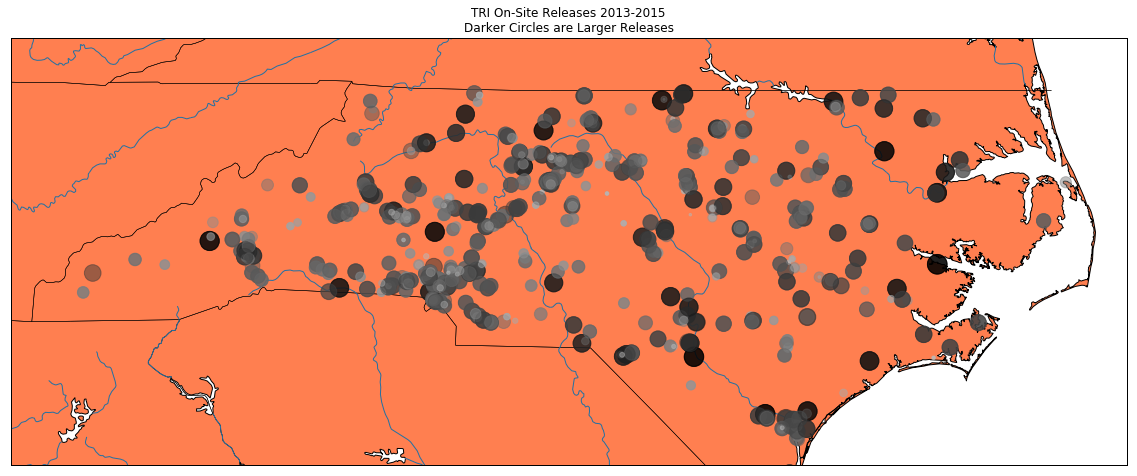

In [20]:
plt.figure(figsize = (20,20))

northcarolina = Basemap(projection='merc', resolution='h',
                     llcrnrlon = -84.5, urcrnrlon = -75.2,
                     llcrnrlat = 34.0, urcrnrlat = 36.9)

northcarolina.drawcountries()
northcarolina.drawstates()
northcarolina.drawcoastlines()
northcarolina.drawrivers(linewidth = 1, color='#2471a3')
northcarolina.fillcontinents(color = 'coral')
northcarolina.drawmapboundary()

    
x13, y13 = northcarolina(tri2013NC.LONGITUDE.values, tri2013NC.LATITUDE.values)
x14, y14 = northcarolina(tri2014NC.LONGITUDE.values, tri2014NC.LATITUDE.values)
x15, y15 = northcarolina(tri2015NC.LONGITUDE.values, tri2015NC.LATITUDE.values)


northcarolina.scatter(x13, y13, s=tri2013NCweights, c=tri2013NCweights, marker='o', alpha=.5, zorder=10, cmap='Greys')
northcarolina.scatter(x14, y14, s=tri2014NCweights, c=tri2014NCweights, marker='o', alpha=.5, zorder=10, cmap='Greys')
northcarolina.scatter(x15, y15, s=tri2015NCweights, c=tri2015NCweights, marker='o', alpha=.5, zorder=10, cmap='Greys')

plt.title("TRI On-Site Releases 2013-2015\nDarker Circles are Larger Releases")
plt.show()